In [24]:
import torch
import tqdm 
import torchvision
import numpy as np
from PIL import Image
from torchvision.transforms import ToTensor, ToPILImage
import matplotlib.pyplot as plt
# torch random normal
from diffusers import UNet2DModel

The reverse process follows a markov chain with learned transitions.
$$p_\theta\left(\mathbf{x}_{0: T}\right):=p\left(\mathbf{x}_T\right) \prod_{t=1}^T p_\theta\left(\mathbf{x}_{t-1} \mid \mathbf{x}_t\right), \quad p_\theta\left(\mathbf{x}_{t-1} \mid \mathbf{x}_t\right):=\mathcal{N}\left(\mathbf{x}_{t-1} ; \boldsymbol{\mu}_\theta\left(\mathbf{x}_t, t\right), \mathbf{\Sigma}_\theta\left(\mathbf{x}_t, t\right)\right)$$
The forward process is a markov chain that gradually adds noise.
$$q\left(\mathbf{x}_{1: T} \mid \mathbf{x}_0\right):=\prod_{t=1}^T q\left(\mathbf{x}_t \mid \mathbf{x}_{t-1}\right), \quad q\left(\mathbf{x}_t \mid \mathbf{x}_{t-1}\right):=\mathcal{N}\left(\mathbf{x}_t ; \sqrt{1-\beta_t} \mathbf{x}_{t-1}, \beta_t \mathbf{I}\right)$$
We can sample in closed form like 
$$q\left(\mathbf{x}_t \mid \mathbf{x}_0\right)=\mathcal{N}\left(\mathbf{x}_t ; \sqrt{\bar{\alpha}_t} \mathbf{x}_0,\left(1-\bar{\alpha}_t\right) \mathbf{I}\right)$$
Where $\alpha_t:=1-\beta_t$ and $\bar{\alpha}_t:=\prod_{s=1}^t \alpha_s$

First we are going to implement a forward noising function $q(x_t|x_0)$. I'll start by defining $\beta_t$. In the paper they use a linear noise scheduler, where $\beta_1 = 1e-4$ and $\beta_T=0.02$ where the total number of steps $T=1000$. From $\beta_t$ we can then define $\alpha_t$ and $\bar{\alpha}_t$. 

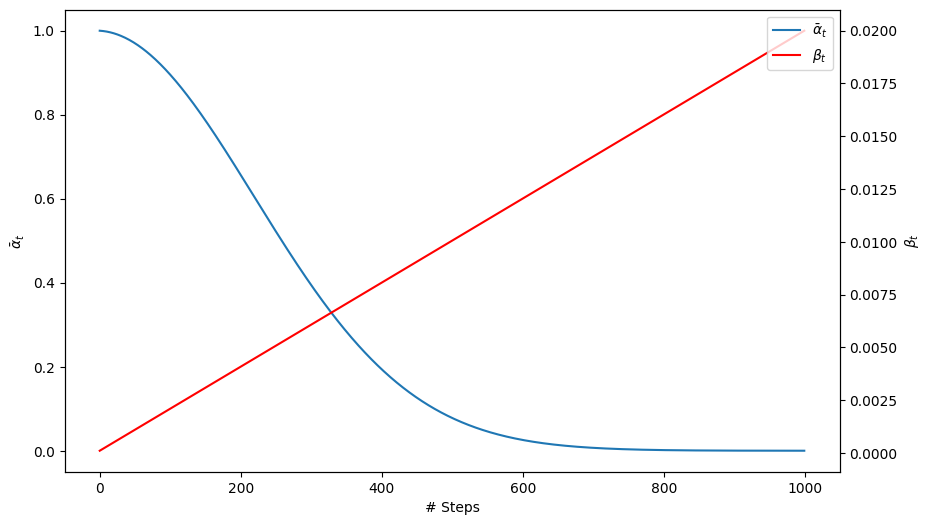

In [ ]:
# Define constants
T = 1000
# Calculate beta_t and alpha_t
beta_t = np.linspace(1e-4, 0.02, T)
alpha_t = 1 - beta_t
# Calculate cumulative product of alpha_t
alpha_bar_t = np.cumprod(alpha_t)

# The rest of the code is just for plotting

plt.figure(figsize=(10, 6))
alpha_line, = plt.plot(alpha_bar_t, label=r'$\bar{\alpha}_t$')
plt.xlabel('# Steps')
plt.ylabel(r'$\bar{\alpha}_t$')
ax2 = plt.twinx()
beta_line, = plt.plot(beta_t, color='red', label=r'$\beta_t$')
plt.ylabel(r'$\beta_t$')
plt.legend(handles=[alpha_line, beta_line], labels=[r'$\bar{\alpha}_t$', r'$\beta_t$'], loc='upper right')
plt.show()

Recall that we can sample in closed form from $q\left(\mathbf{x}_t \mid \mathbf{x}_0\right)=\mathcal{N}\left(\mathbf{x}_t ; \sqrt{\bar{\alpha}_t} \mathbf{x}_0,\left(1-\bar{\alpha}_t\right) \mathbf{I}\right)$. We see that $\alpha_T≈0$, for that we get $q\left(\mathbf{x}_T \mid \mathbf{x}_0\right)=\mathcal{N}\left(\mathbf{x}_T ; 0, \mathbf{I}\right)$, i.e. our initial noise is sampled from a standard normal distribtion. $q\left(\mathbf{x}_t \mid \mathbf{x}_0\right)= \sqrt{\bar{\alpha}_t}\mathbf{x}_0+(1-\sqrt{\bar{\alpha}_t})\epsilon$, where $\epsilon \sim \mathcal{N}\left(0,1\right)$.

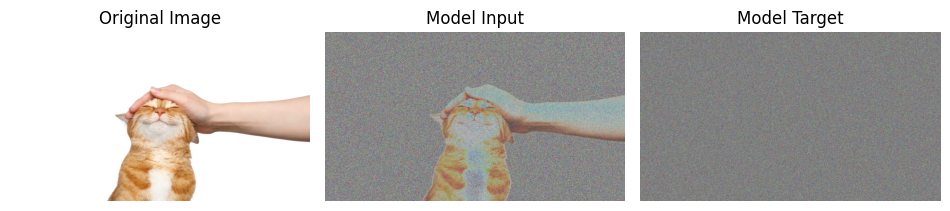

In [39]:
totensor = ToTensor()
# sample from normal distribution
t = 50
img = Image.open('cat.jpg')
img = totensor(img)
out = forward_process(img,t )
# Convert tensors to PIL images
topil = ToPILImage()
sample_pil = topil(out["img"])
target_pil = topil(out["target"])
img = topil(img)
# Create a figure with two subplots
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
# Plot the sample image
ax[0].imshow(img)
ax[0].set_title('Original Image')
ax[0].axis('off')
# Plot the sample image
ax[1].imshow(sample_pil)
ax[1].set_title('Model Input')
ax[1].axis('off')
# Plot the target image
ax[2].imshow(target_pil)
ax[2].set_title('Model Target')
ax[2].axis('off')
# Remove the space between subplots
plt.subplots_adjust(wspace=0.05)
# Show the plot
plt.show()

Here I use the MSE loss, which the paper found to be more practical to implement
$$
\begin{aligned}
&\text { Algorithm } 1 \text { Training }\\
&\text { repeat }\\
&\mathbf{x}_0 \sim q\left(\mathbf{x}_0\right)\\
&t \sim \operatorname{Uniform}(\{1, \ldots, T\})\\
&\boldsymbol{\epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})\\
&\text { Take gradient descent step on }\\
&\nabla_\theta\left\|\boldsymbol{\epsilon}-\boldsymbol{\epsilon}_\theta\left(\sqrt{\bar{\alpha}_t} \mathbf{x}_0+\sqrt{1-\bar{\alpha}_t} \boldsymbol{\epsilon}, t\right)\right\|^2\\
&\text { until converged }
\end{aligned}
$$

In [69]:
from torch.utils.data import Dataset
transform = ToTensor()

device = "cpu" #torch.device('mps')
model = UNet2DModel()

class DiffDataset(Dataset):
    def __init__(self):
        self.dataset = torchvision.datasets.CIFAR10(root="cifar-10-batches-py", download=True, transform=transform)
        self.T = 1000
        self.beta_t = np.linspace(1e-4, 0.02, self.T)
        self.alpha_t = 1 - self.beta_t
        self.alpha_bar_t = np.cumprod(self.alpha_t)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        # sample t
        t = np.random.randint(0, self.T)
        # define the forward process    
        out = self.forward_process(item[0], t)
        return out
    
    def forward_process(self, img, t):
        epsilon = torch.randn(img.size())
        sample = np.sqrt(self.alpha_bar_t[t])*img + np.sqrt(1-self.alpha_bar_t[t])*epsilon
        return {"img": sample, "target": epsilon, "t": t}

dataset = DiffDataset()
# split into train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
# define dataloader
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
# define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Files already downloaded and verified


In [63]:

for epoch in tqdm.tqdm(range(10)):
    for batch in dataloader:
        out = model(batch["img"], batch["t"])
        loss = torch.nn.functional.mse_loss(out["sample"], batch["target"])
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print("Done!")
        
    
    with torch.no_grad():
        for batch in val_dataloader:
            model(batch["img"], batch["t"])


  0%|          | 0/10 [00:05<?, ?it/s]


KeyboardInterrupt: 

In [39]:
# import resize
from torchvision.transforms import Resize

resize = Resize((256, 256))
img = out['img']
img = resize(img)
model(out["img"].unsqueeze(0), torch.tensor([t]))

: 

Files already downloaded and verified


torch.Size([1, 3, 32, 32])